In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [2]:
#@title Download dataset

!git clone https://github.com/LapTQ/facial_beauty_perception
!git clone https://github.com/LapTQ/mlapplications.git
!pwd

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11651, done.
remote: Counting objects: 100% (11651/11651), done.
remote: Compressing objects: 100% (11634/11634), done.
remote: Total 11651 (delta 402), reused 11036 (delta 14), pack-reused 0
Receiving objects: 100% (11651/11651), 248.02 MiB | 12.98 MiB/s, done.
Resolving deltas: 100% (402/402), done.
Checking out files: 100% (11020/11020), done.
Cloning into 'mlapplications'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 35 (delta 9), reused 24 (delta 9), pack-reused 11
Unpacking objects: 100% (35/35), done.
/content


In [ ]:
#@title Import library and utilities

!pip install git+https://github.com/tensorflow/docs
!pip install tf-keras-vis tensorflow

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.layers import BatchNormalization, Conv2D, Dropout, Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import max_norm

import pathlib
# import tempfile
# import shutil
# from IPython import display

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam

seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def plot_img(img, scores, labels):
    scores = [np.squeeze(i) for i in scores]
    plt.imshow(np.squeeze(img), cmap='gray' if channels == 1 else 'viridis')
    
    if len(labels) == 2:
        plt.title('true: %.2f | pred: %.2f' % (scores[0], scores[1]))
    else:
        plt.title('%s: %.2f' % (labels[0], scores[0]))

    plt.axis('off')

def plot_scores(scores, labels):
    scores = [np.squeeze(i) for i in scores]
    this_plot = plt.bar(labels, scores)
    if len(labels) == 2:
        this_plot[0].set_color('green')
        this_plot[1].set_color('firebrick')
    elif labels[0] == 'true':
        this_plot[0].set_color('green')
    else:
        this_plot[0].set_color('firebrick')
    plt.yticks(range(6))

img_dir_path = 'facial_beauty_perception/FBP5500/Images/'

### Load images

In [4]:
#@title Choose hyper-parameter
image_size =  224#@param [224] {allow-input: true} {type:"integer"}

batch_size = "32" #@param [32, 64, 128, 256]

channels = "3" #@param [1, 3]

image_size = (image_size, image_size)
batch_size = int(batch_size)
channels = int(channels)

input_shape = image_size + (channels,)

scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(image_size[0], image_size[1], crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255), # use offset=-1 if wanted it to be [-1, 1]
     ]
)

print('batch input shape:', (batch_size,) + input_shape)

batch input shape: (32, 224, 224, 3)


In [ ]:
#@title Show some statistics of the dataset

print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40)
plt.xlabel('Score')
plt.ylabel('Number of images')
plt.title('Histogram of facial images scores')
plt.show()

In [ ]:
#@title Show some images and their beauty score
group = '4' #@param [1, 2, 3, 4]
n = 64 #@param {type:"integer"}
shift = 0 #@param {type:"integer"}
gender = 'Female' #@param ['Female', 'Male']

group = int(group)
gender = gender[0]

group = int(group)

def plot_faces(group, n, shift, gender):
    i = j = 0
    num_cols = 6
    num_rows = math.ceil(n / num_cols)
    plt.figure(figsize=(2*2*num_cols, 3*num_rows))
    spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[12, 1]*num_cols)
    while i < 64 and shift + j < 5500:
        if shift + j < 5500 and group < scores_dataframe['score'][shift + j] < group + 1 and scores_dataframe['file_name'][shift + j][1] == gender:
            img = image.load_img(img_dir_path + scores_dataframe['file_name'][shift + j], target_size=image_size, color_mode="grayscale" if channels == 1 else 'rgb')
            img = image.img_to_array(img)
            img = resize_and_scale(img)

            true = scores_dataframe['score'][shift + j]

            plt.subplot(spec[2*i])
            plot_img(img, [true], [scores_dataframe['file_name'][shift + j][:-4]])

            plt.subplot(spec[2*i + 1])
            plot_scores([true], ['true'])

            i += 1
        
        j += 1

    plt.tight_layout()
    plt.show()

plot_faces(group, n, shift, gender)

### Choose test-size split ratio and prepare dataset

In [9]:
#@title Choose test-size ratio
test_size = 0.2 #@param {allow-input: true}

train_scores_df, test_scores_df = train_test_split(scores_dataframe, test_size=test_size, shuffle=True, random_state=seed)

print('%d images for train_ds' % (len(train_scores_df)))
print('%d images for test_ds' % (len(test_scores_df)))

4400 images for train_ds
1100 images for test_ds


In [21]:
#@title Prepare dataset and do augmentation

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("horizontal"),
     tf.keras.layers.RandomRotation(0.06),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.5, 0.12)),
     tf.keras.layers.RandomTranslation(0.14, 0.14)
     ]
)

def filename_to_img(filename, label):
    img_string = tf.io.read_file(img_dir_path + filename)
    
    # Don't use tf.image.decode_image, or the output shape will be undefined
    img = tf.image.decode_jpeg(img_string, channels=channels)

    # This will convert to float values in [0, 1]
    # img = tf.image.convert_image_dtype(img, tf.float32)

    # img = tf.image.resize(img, image_size)

    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_scores_df['file_name'], train_scores_df['score']))
test_ds = tf.data.Dataset.from_tensor_slices((test_scores_df['file_name'], test_scores_df['score']))

def configure_dataset(ds, training, fine_tune):
    ds = ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=5500)
    # ds = ds.map(lambda x, y: (resize_and_scale(x), y))
    ds = ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1], crop_to_aspect_ratio=True)(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    if not fine_tune:
        ds = ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255, offset=-1)(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(buffer_size=5500)
    ds = ds.batch(batch_size)
    
    return ds

train_ds = configure_dataset(train_ds, training=True, fine_tune=True)
test_ds = configure_dataset(test_ds, training=False, fine_tune=True)

print('train_ds and test_ds configured.')

train_ds and test_ds configured.


In [ ]:
#@title Plot 1 batch augmented train dataset

do_plot = 'yes' #@param ['no', 'yes']

if do_plot == 'yes':

    plt.figure(figsize=(20, 10))
    for img, sco in train_ds.take(1):
        print(img.shape)
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            if channels == 1:
                plt.imshow(np.squeeze(img[i], axis=-1), cmap='gray')
            else:
                plt.imshow(img[i])
            plt.axis("off")
    plt.show()

### Utilities

In [ ]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
models = {}
lr_record = {}
epoch_record = {}
histories = {}

In [ ]:
def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del lr_record[name]
        del epoch_record[name]
    except:
        pass

In [ ]:
############################### handle trường hợp tiny data

def train_model(model, optimizer, max_epochs, reduce_lr_patience, early_stop_patience, checkpoint_name):

    print('[TRAINING] ', model.name)

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, verbose=1),
                #  tf.keras.callbacks.TensorBoard(logdir/model.name)
                ]
    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor='val_loss', verbose=1, save_best_only=True))
    
    # shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if model.name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(model.name)) != 'y':
        new_model = False
    
    set_seed(seed)

    if new_model:
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.MeanAbsoluteError()
        )
        histories[model.name] = model.fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,
            validation_data=test_ds,
            callbacks=callbacks,
            shuffle=True
        )
        epoch_record[model.name] = [histories[model.name].epoch[-1]]
        # lr_record[model.name] = [optimizer.get_config()['learning_rate']]

    else:
        model.optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])
        cont_history = model.fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,     
            validation_data=test_ds,    
            callbacks=callbacks,
            initial_epoch=histories[model.name].epoch[-1] + 1,
            shuffle=True
        )
        epoch_record[model.name].append(cont_history.epoch[-1])
        # lr_record[name].append(optimizer.get_config()['learning_rate'])
        histories[model.name].epoch += cont_history.epoch
        histories[model.name].history['loss'] += cont_history.history['loss']
        histories[model.name].history['val_loss'] += cont_history.history['val_loss']

    return model.name


plotter = tfdocs.plots.HistoryPlotter( 
    # metric = 'nonregu_mae',
    # smoothing_std=10
)

### Check if model works

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
plot_activations(model, images[1])

#### Thử mô hình tự tạo :((

In [ ]:
# Fine-tuning

inputs = Input(shape=(None, None, None))
x = data_augmentation(inputs)
base_model = tf.keras.applications.Xception(include_top=False, input_shape=input_shape, weights=None)
x = base_model(x, training=False)
x = Flatten()(x)
outputs = Dense(1)(x)
models['1'] = Model(inputs=inputs, outputs=outputs)

train_model('1', SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), max_epochs=50, reduce_lr_patience=3, early_stop_patience=10, checkpoint_name='checkpoint')

In [ ]:
models['kt2'] = keras.Sequential(
        [
         Conv2D(8, 3, activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(32, 3, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         Conv2D(16, 3, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(8, 5, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(128, 5, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(256, 5, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(128, 5, activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(256, 7, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(256, 5, activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(512, 3, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         Conv2D(512, 3, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(256, 3, padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         Conv2D(128, 3, activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         Conv2D(128, 3, activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         GlobalAveragePooling2D(),
         Dense(1)
        ]
    )


{'kt2': [0.001, 0.001], 'kt3': [0.001, 0.001]}
{'kt2': [18, 38], 'kt3': [23, 37]}


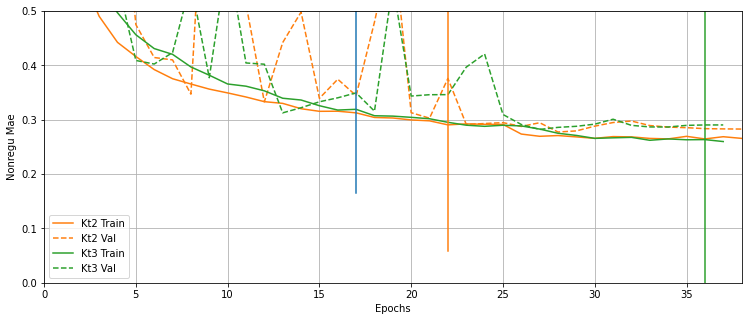

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
plt.ylim([0, 0.5])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

In [ ]:
models['kt2'].save('/content/drive/MyDrive/checkpoint/kt2_0277')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/kt2_0277/assets


### Keras tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.7 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):

    units_choices = [8, 16, 32, 64, 128, 256, 512]
    filter_size_choices = [3, 5, 7]

    model = keras.Sequential(
        [
         Conv2D(hp.Choice(name='unit_conv1', values=units_choices[:4]), hp.Choice(name='f_conv1', values=filter_size_choices), activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv2', values=units_choices[:4]), hp.Choice(name='f_conv2', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv3', values=units_choices[:4]), hp.Choice(name='f_conv3', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         
         Conv2D(hp.Choice(name='unit_conv4', values=units_choices[:4]), hp.Choice(name='f_conv4', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv5', values=units_choices[:4]), hp.Choice(name='f_conv5', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(hp.Choice(name='unit_conv6', values=units_choices[4:]), hp.Choice(name='f_conv6', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv7', values=units_choices[4:]), hp.Choice(name='f_conv7', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(hp.Choice(name='unit_conv8', values=units_choices[4:]), hp.Choice(name='f_conv8', values=filter_size_choices), activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv9', values=units_choices[4:]), hp.Choice(name='f_conv9', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv10', values=units_choices[4:]), hp.Choice(name='f_conv10', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
         MaxPooling2D(3, strides=2),

         Conv2D(hp.Choice(name='unit_conv11', values=units_choices[4:]), hp.Choice(name='f_conv11', values=filter_size_choices), activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv12', values=units_choices[4:]), hp.Choice(name='f_conv12', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),

         Conv2D(hp.Choice(name='unit_conv13', values=units_choices[4:]), hp.Choice(name='f_conv13', values=filter_size_choices), padding='same', activation='relu', kernel_constraint=max_norm(2)),
         BatchNormalization(),
        #  MaxPooling2D(3, strides=2),
         
         GlobalAveragePooling2D(),
         Dense(1)
        ]
    )

    model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
                  loss=tf.keras.losses.MeanAbsoluteError()
                  )
    
    return model

tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=30,
    factor=2,
    directory='/content/drive/MyDrive/checkpoint',
    project_name='kt',
    overwrite=True,
)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1),
            ]

tuner.search(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 83 Complete [00h 05m 57s]
val_loss: 0.4305282235145569

Best val_loss So Far: nan
Total elapsed time: 00h 50m 38s

Search: Running Trial #84

Hyperparameter    |Value             |Best Value So Far 
unit_conv1        |8                 |16                
f_conv1           |5                 |11                
unit_conv2        |32                |16                
f_conv2           |7                 |3                 
unit_conv3        |32                |32                
f_conv3           |7                 |7                 
unit_conv4        |32                |16                
f_conv4           |5                 |5                 
unit_conv5        |512               |128               
f_conv5           |7                 |11                
unit_conv6        |512               |128               
f_conv6           |5                 |3                 
unit_conv7        |256               |256               
f_conv7           |7                 |5               

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))



hypermodel = tuner.hypermodel.build(best_hyperparameters)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

### Advance

In [ ]:
models['checkpoint'] = get_model_v2()

In [ ]:
models['3'].load_weights('/content/drive/MyDrive/checkpoint/checkpoint3.hdf5')

In [ ]:
list(enumerate(models['pretrained_model'].layers))

In [ ]:
models['2'].summary()

In [ ]:
plot_layer_output('kt', layer=10, image_index=2)

## Test result

In [ ]:
predictions = models['kt2'].predict(test_ds)
models['kt2'].evaluate(test_ds)

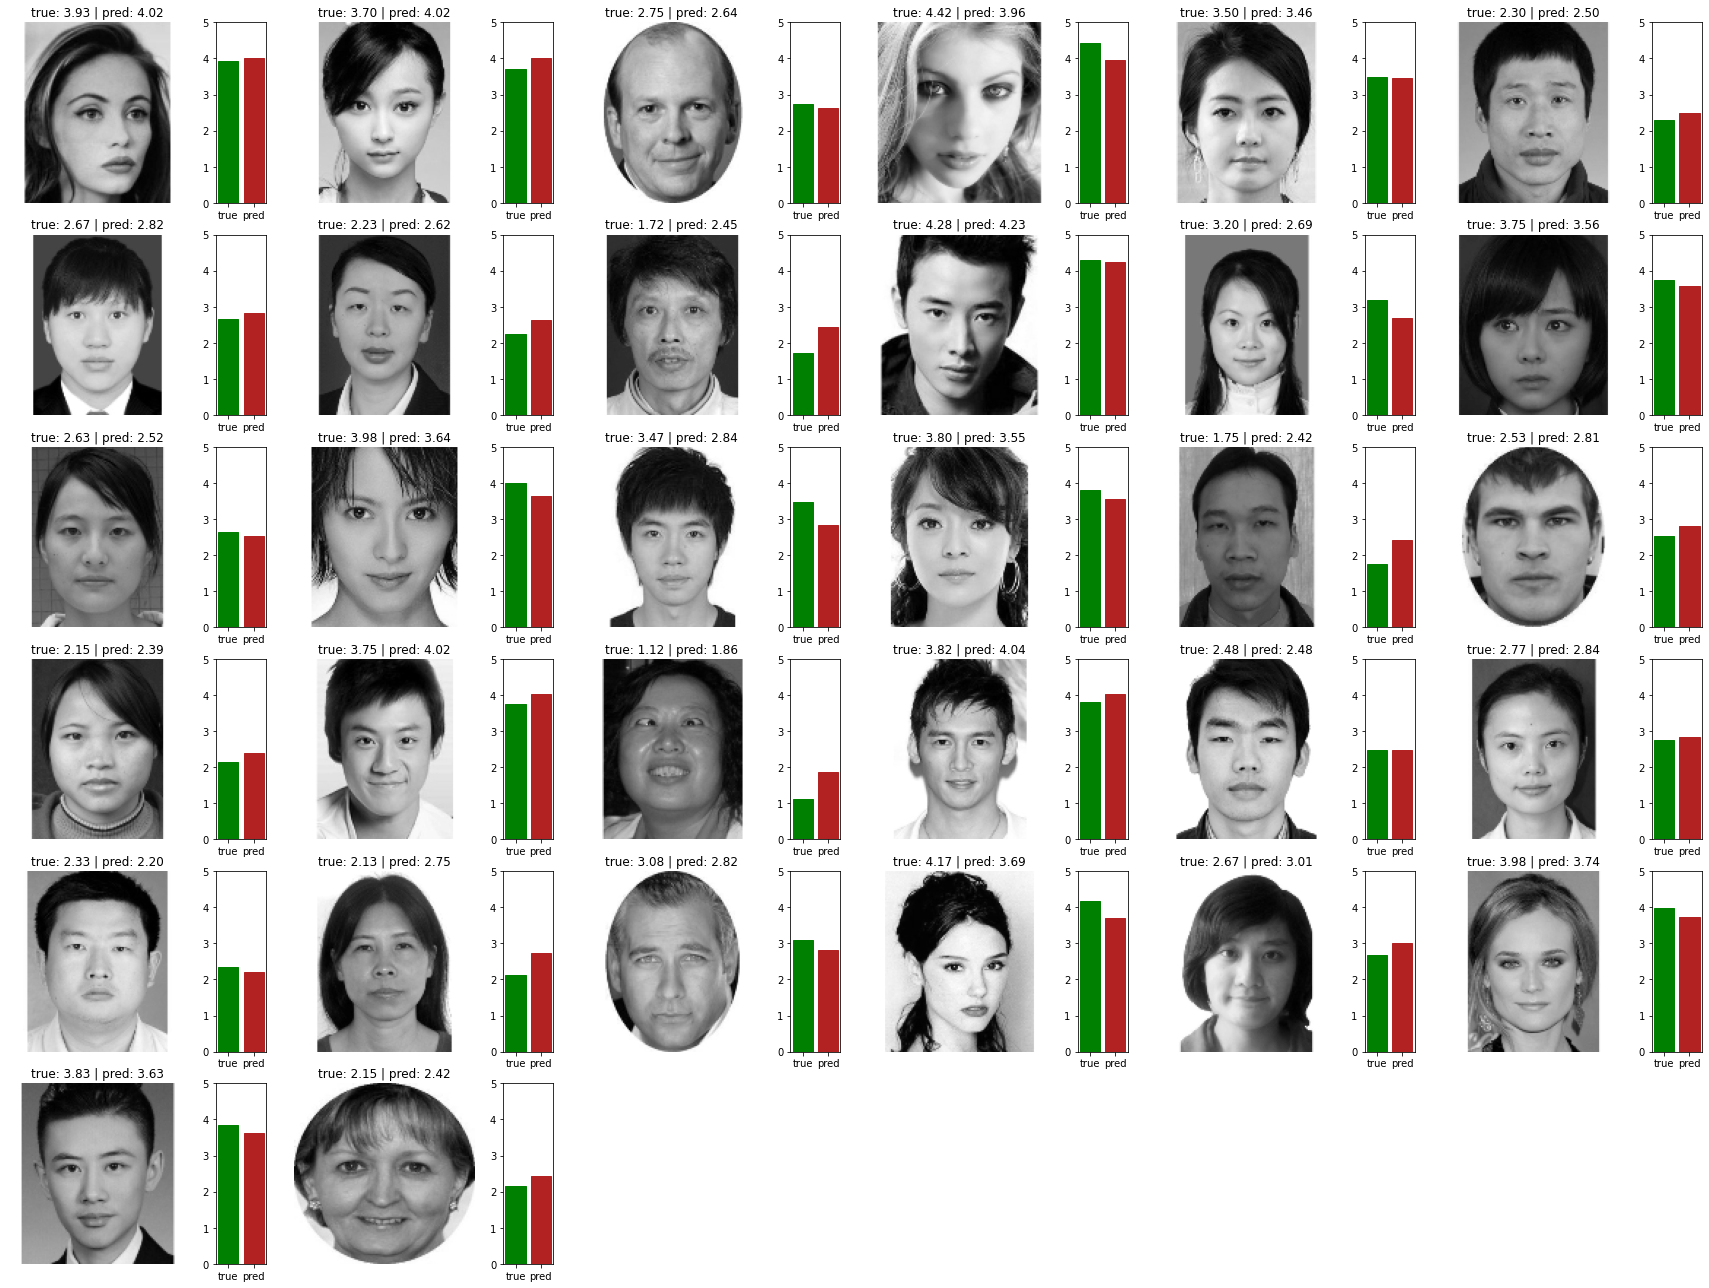

In [ ]:
#@title Show some test prediction results

n = 32 #@param {type:'integer'}

num_cols = 6
num_rows = math.ceil(n / num_cols)
plt.figure(figsize=(2*2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[4, 1]*num_cols)
for i in range(n):
    img = image.load_img(test_scores_df['file_name'].to_numpy()[i], color_mode=('grayscale' if channels == 1 else 'rgb'))
    img = image.img_to_array(img)
    img = resize_and_scale(img)

    true = test_scores_df['score'].to_numpy()[i]
    pred = predictions[i]

    plt.subplot(spec[2*i])
    plot_img(img, [true, pred], ['true', 'pred'])

    plt.subplot(spec[2*i + 1])
    plot_scores([true, pred], ['true', 'pred'])

plt.tight_layout()
plt.show()

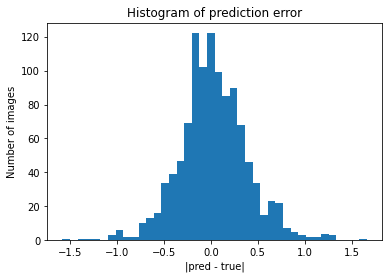

In [ ]:
#@title Plot prediction error

pred = np.squeeze(predictions)
true = test_scores_df['score'].to_numpy()

print("Pearson correlation between true score and predicted score on test set:")
print(np.corrcoef(pred, true))

plt.hist(pred - true, bins=40)
plt.xlabel('|pred - true|')
plt.ylabel('Number of images')
plt.title('Histogram of prediction error on test set')
plt.show()

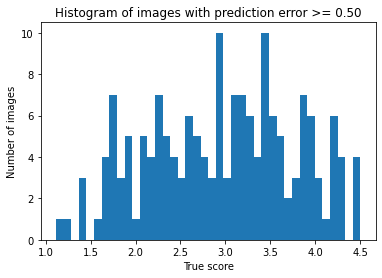

166/1100 images with prediction error >= 0.50


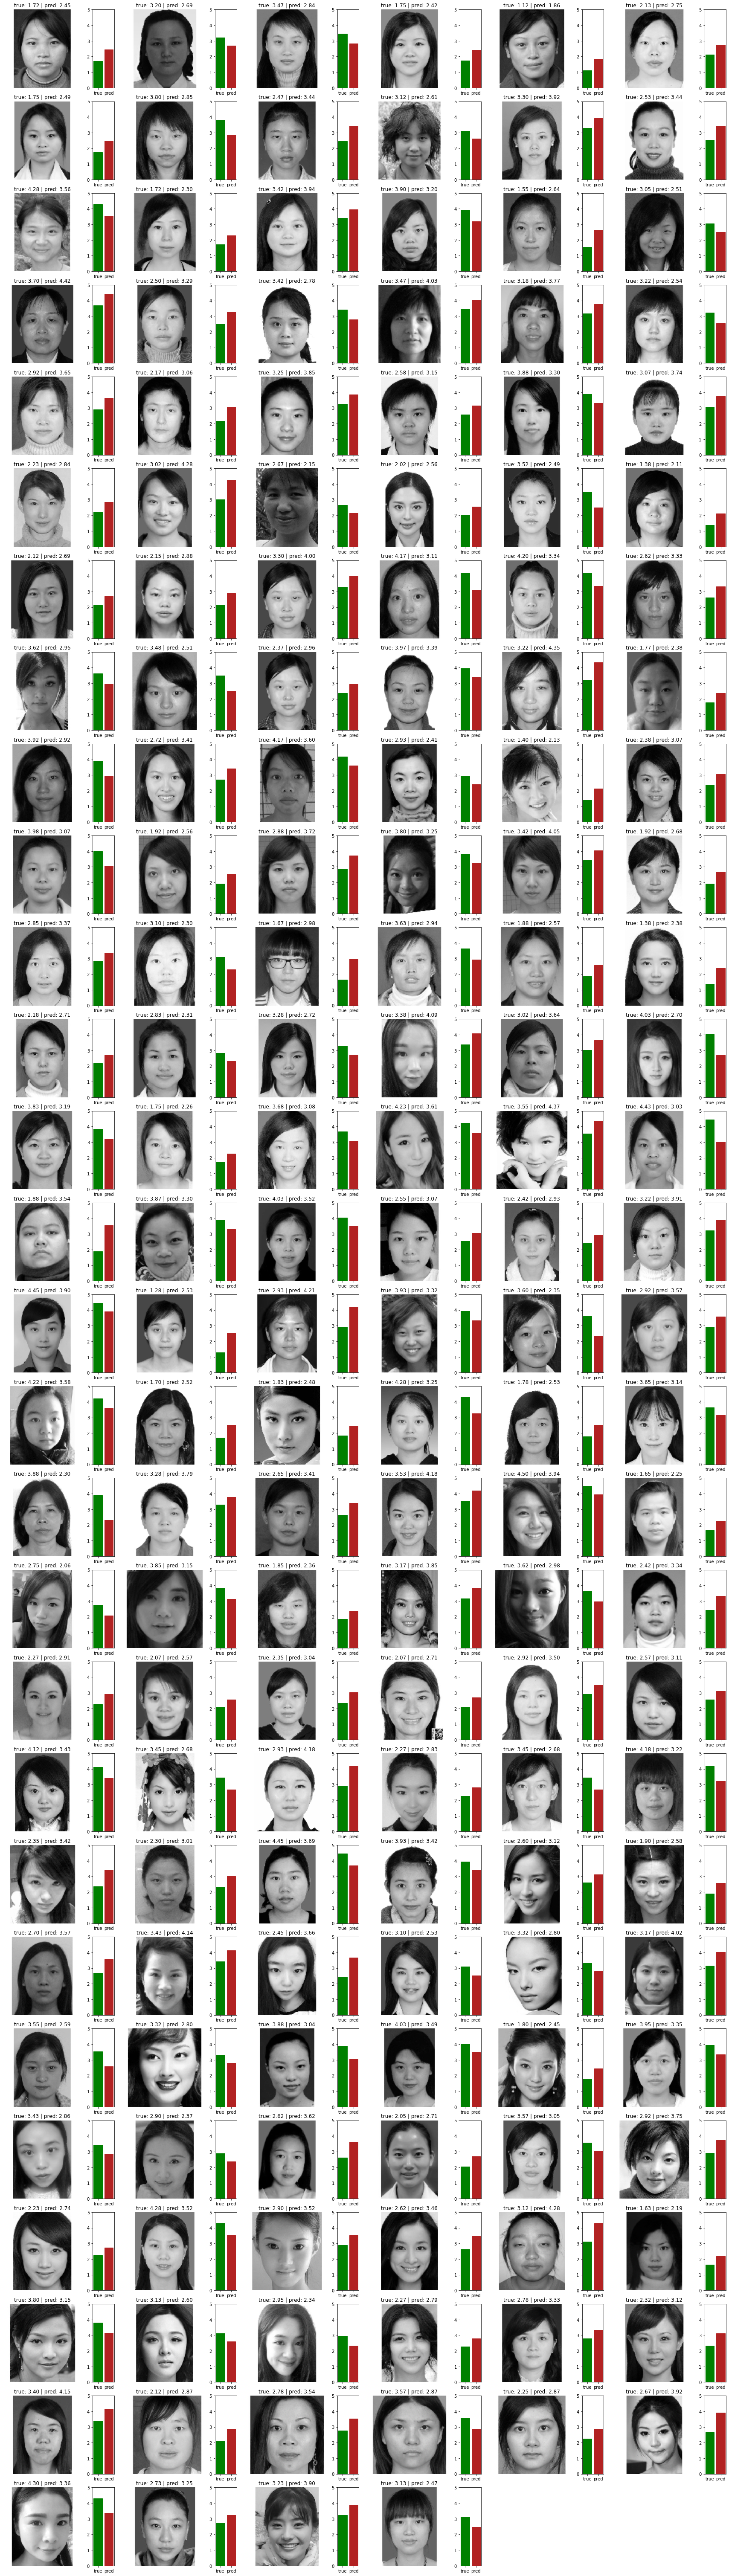

In [ ]:
#@title Show images that are not well predicted
threshold = 0.5 #@param {type:"number"}

sub = np.abs(np.squeeze(predictions) - test_scores_df['score'].to_numpy())
plt.hist(test_scores_df['score'].to_numpy()[sub >= threshold], bins=40)
plt.xlabel('True score')
plt.ylabel('Number of images')
plt.title('Histogram of images with prediction error >= {:.2f}'.format(threshold))
plt.show()

print('{}/{} images with prediction error >= {:.2f}'.format(len(sub[sub >= threshold]), len(sub), threshold))
num_cols = 6
num_rows = math.ceil(len(sub[sub >= threshold]) / num_cols)
plt.figure(figsize=(2*2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[4, 1]*num_cols)
j = 0
for i in range(len(sub)):
    if sub[i] >= threshold:
        img = image.load_img(img_dir_path + scores_dataframe['file_name'][i], target_size=image_size, color_mode="grayscale" if channels == 1 else 'rgb')
        img = image.img_to_array(img)
        img = resize_and_scale(img)

        true = test_scores_df['score'].to_numpy()[i]
        pred = predictions[i]

        plt.subplot(spec[2*j])
        plot_img(img, [true, pred], ['true', 'pred'])

        plt.subplot(spec[2*j + 1])
        plot_scores([true, pred], ['true', 'pred'])

        j += 1

plt.tight_layout()
plt.show()


## Visualize

In [ ]:
model = tf.keras.models.load_model('mlapplications/trained_models/fbp')

In [ ]:
img = image.load_img(img_dir_path + 'AF300.jpg', color_mode='grayscale' if channels == 1 else None)
img = image.img_to_array(img)
img = resize_and_scale(img)

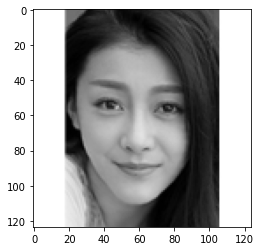

In [ ]:
vis_heatmap(model, img, 4)

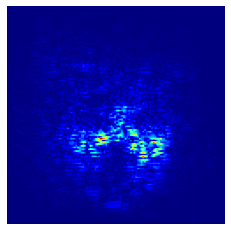

In [ ]:
vis_saliency(model, img, 4)

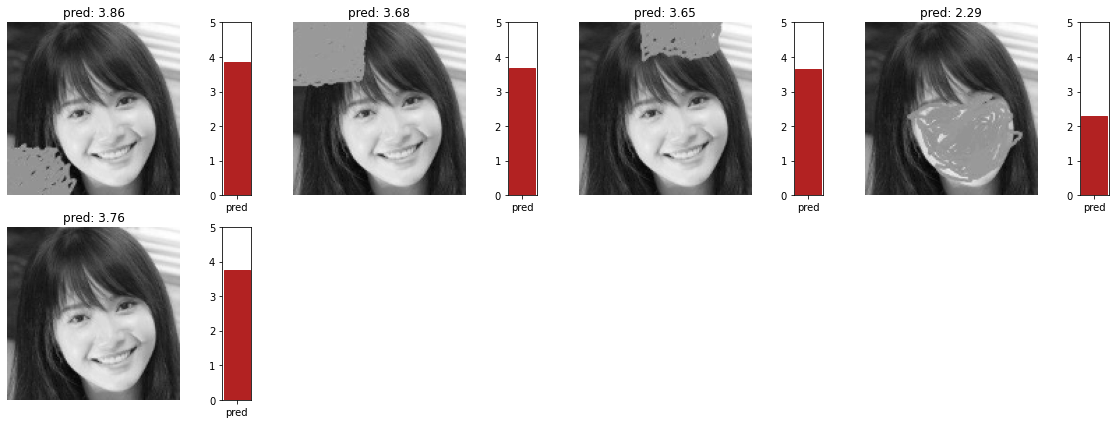

In [ ]:
#@title See which patch of pixel matters

img_dir = '/content/facial_beauty_perception/a' #@param {type:"string"}
img_dir = pathlib.Path(img_dir)

img_paths = list(img_dir.glob('*.jpg'))

num_cols = 4
num_rows = math.ceil(len(img_paths) / num_cols)
plt.figure(figsize=(2*2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[8, 1]*num_cols)
for i in range(len(img_paths)):
    img = image.load_img(str(img_paths[i]), color_mode='grayscale' if channels == 1 else None)
    img = image.img_to_array(img)
    img = resize_and_scale(img)

    pred = model.predict(np.expand_dims(img, axis=0))

    plt.subplot(spec[2*i])
    plot_img(img, [pred], ['pred'])

    plt.subplot(spec[2*i + 1])
    plot_scores([pred], ['pred'])

plt.tight_layout()
plt.show()




In [ ]:
#@title Define visualization functions

def vis_heatmap(model, img, score):

    def score_function(output):
        return 1.0 / (tf.math.abs(output[:] - score) + tf.keras.backend.epsilon())

    model_cam = GradcamPlusPlus(
        model,
        model_modifier=ReplaceToLinear(),
        clone=True
    )

    cam = model_cam(
        score_function,
        img,
        penultimate_layer=-1
    )

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    plt.imshow(np.squeeze(img), cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.axis('off')


def vis_saliency(model, img, score):

    def score_function(output):
        return 1.0 / (tf.math.abs(output[:] - score) + tf.keras.backend.epsilon())

    model_saliency = Saliency(
        model,
        model_modifier=ReplaceToLinear(),
        clone=True
    )

    saliency_map = model_saliency(
        score_function, 
        img
    )

    plt.imshow(saliency_map[0], cmap='jet')
    plt.axis('off')


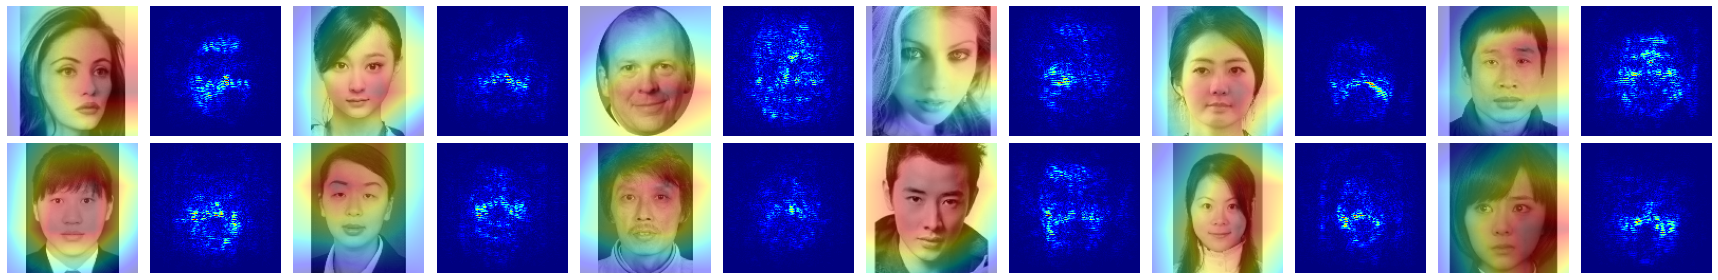

In [ ]:
#@title Plot heatmap and saliency map of some images in test set

img_num = 12 #@param {type:"integer"}

num_cols = 6
num_rows = math.ceil(img_num / num_cols)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows)

i = 0
for img_batch, score_batch in test_ds.take(1):
    for img, score in zip(img_batch, score_batch):

        plt.subplot(spec[2*i])
        vis_heatmap(model, img, score.numpy())

        plt.subplot(spec[2*i + 1])
        vis_saliency(model, img, score.numpy())

        i += 1

        if i == img_num:
            break

plt.tight_layout()
plt.show()

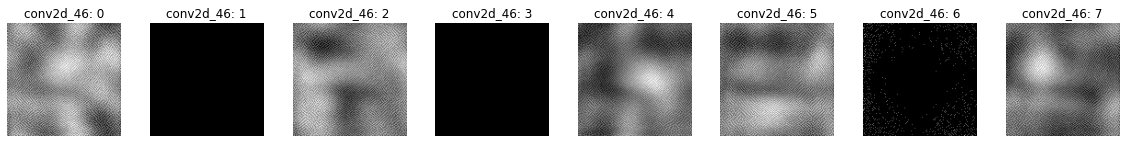

In [ ]:
#@title Plot conv layers with activation maximization

layer_name = 'conv2d_46' #@param {type:"string"}

max_layer = 16 #@param {type:"integer"}

n = min(model.get_layer(name=layer_name).filters, max_layer)        
filter_numbers = list(range(n))     # choose first n layers

scores = CategoricalScore(filter_numbers)
seed_input = tf.random.uniform((n, 124, 124, 1), 0, 255)

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer(index_or_name=layer_name), 
                                                                 ReplaceToLinear()
                                                                 ],
                                                 clone=False)

activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

num_cols = 8
num_rows = math.ceil(n / num_cols)
plt.figure(figsize=(2*num_cols, 2*num_rows))
spec = gridspec.GridSpec(ncols=num_cols, nrows=num_rows)

for i, filter_number in enumerate(filter_numbers):

        plt.subplot(spec[i])
        plt.imshow(np.squeeze(activations[i]), cmap='gray')
        plt.title('{}: {}'.format(layer_name, filter_number))
        plt.axis('off')

plt.tight_layout()
plt.show()

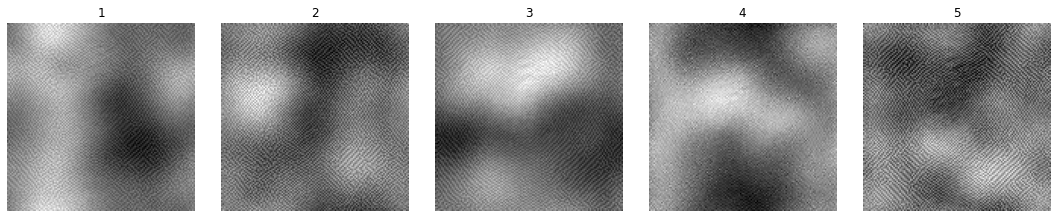

In [ ]:
#@title Plot dense layers with activation maximization


activation_maximization = ActivationMaximization(model,
                                                 model_modifier=ReplaceToLinear(),
                                                 clone=True)


num_cols = 5
num_rows = 1
plt.figure(figsize=(3*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=num_cols, nrows=num_rows)

for i in range(1, 6, 1):
    
    def score_function(output):
        return 1.0 / (tf.math.abs(output[:] - i) + tf.keras.backend.epsilon())

    plt.subplot(spec[i - 1])
    activations = activation_maximization(score_function)
    plt.imshow(np.squeeze(activations[0]), cmap='gray')
    plt.title(i)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 122, 122, 8)       80        
                                                                 
 batch_normalization_44 (Bat  (None, 122, 122, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_47 (Conv2D)          (None, 122, 122, 32)      2336      
                                                                 
 batch_normalization_45 (Bat  (None, 122, 122, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_48 (Conv2D)          (None, 122, 122, 16)      4624      
                                                                 
 batch_normalization_46 (Bat  (None, 122, 122, 16)    

# Tải lên ảnh từ máy tính

In [ ]:
fbp_model = tf.keras.models.load_model('mlapplications/trained_models/fbp')

Saving 00.png to 00.png
Uploaded "00.png" of 74863 bytes


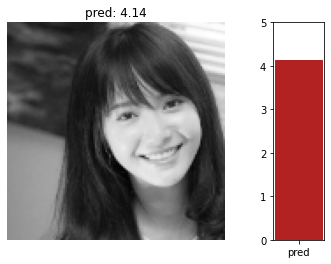

In [ ]:
#@title Tải ảnh lên và tiến hành dự đoán

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('Uploaded "{}" of {} bytes'.format(fn, len(uploaded[fn])))

    img = image.load_img(fn, color_mode='grayscale' if channels == 1 else None)
    
    img = image.img_to_array(img)
    img = resize_and_scale(img)

    pred = fbp_model.predict(np.expand_dims(img, axis=0))

    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[5, 1])
    plt.subplot(spec[0])
    plot_img(img, [pred], ['pred'])
    plt.subplot(spec[1])
    plot_scores([pred], ['pred'])

    plt.show()

    